# Aufbau eines Song-Recommenders

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time as time
import joblib
from sklearn.feature_extraction.text import CountVectorizer

# Laden von Musikdaten

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
song_csv=pd.read_csv("/content/drive/MyDrive/tez/song_data.csv")
song_csv.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [4]:
song_txt = pd.read_fwf("/content/drive/MyDrive/tez/10000.txt")
song_txt.head() 

,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5


In [5]:
song_txt.columns = ['user_id','song_id','listen_count']
song_txt.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5


In [6]:
song_df = pd.merge(song_txt, song_csv.drop_duplicates(['song_id']), on="song_id", how="left") 

# Durchsuchen der Daten

Musikdaten zeigen, wie oft ein Benutzer ein Lied angehört hat, und die Details des Lieds.

In [7]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007


## Länge des Datensatzes

In [8]:
len(song_df)

1999999

## Erstellen einer Teilmenge des Datensatzes

In [9]:
song_df = song_df.head(10000)
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

## Zeigt die beliebtesten Songs im Datensatz an

In [10]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4677,Undo - Björk,32,0.32
5104,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5138,high fives - Four Tet,1,0.01
5139,in white rooms - Booka Shade,1,0.01
5142,paranoid android - Christopher O'Riley,1,0.01
5148,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


## Zählen der Anzahl eindeutiger Benutzer in der Registrierung

In [11]:
users = song_df['user_id'].unique()

In [12]:
len(users)

365

Zählen der Anzahl eindeutiger Songs im Datensatz

In [13]:
songs = song_df['song'].unique()
len(songs)

5150

# Songempfehlung erstellen

In [14]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOYOAZI12A8AE46C83   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOYYMNG12AB0187E2B   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOPTXDZ12A8C13518C   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWOZLK12A8C136B33   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAOBEK12AF72A9021   

      listen_count                title                         release  \
7389             1   A Moment Like This                          Spirit   
9275             1   With Blood Adorned         Infinita Plango Vulnera   
2995             2   Un Aro En La Nariz                   //:Tres.Jeans   
5316             1  Doin' The Cockroach  Baron Von Bullshit Rides Again   
356              1           Tchaparian                     The Warning   

         artist_name  year                                 song  
7389     Leona Lewis  2006     A Moment Like This - Leona Lewi

## Einfache, auf Popularität basierende Empfehlungsklasse

In [15]:
from google.colab import files
src = list(files.upload().values())[0]
open('Recommenders.py','wb').write(src)
import Recommenders

Saving recommenders.py to recommenders.py


### Erstellen einer Instanz einer Empfehlungsklasse basierend auf Beliebtheit

In [16]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Verwenden des Popularitätsmodells, um einige Vorhersagen zu treffen

In [17]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3201,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,40,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,30,2.0
4451,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,27,3.0
938,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,25,4.0
3819,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Scientist - Coldplay,23,5.0
4114,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,22,6.0
1569,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,21,7.0
3197,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,8.0
3040,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,20,9.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,18,10.0


Verwenden des auf Popularität basierenden Modells, um Vorhersagen für die folgende Benutzer-ID zu treffen (unter Berücksichtigung des Unterschieds in den Vorschlägen von der ersten Benutzer-ID).

In [18]:
user_id = users[8]
pm.recommend(user_id)


,user_id,song,score,Rank
3201,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,40,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,30,2.0
4451,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,27,3.0
938,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,25,4.0
3819,9bb911319fbc04f01755814cb5edb21df3d1a336,The Scientist - Coldplay,23,5.0
4114,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,22,6.0
1569,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,21,7.0
3197,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,8.0
3040,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,20,9.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,18,10.0


## Erstellen eines Song-Recommenders mit Anpassung

Derzeit wird ein gemeinsames Filtermodell basierend auf Artikelähnlichkeit erstellt, das es uns ermöglicht, jedem Benutzer personalisierte Empfehlungen zu geben.

## Klasse für ein auf Artikelähnlichkeit basierendes personalisiertes Empfehlungssystem 

### Erstellen einer Instanz der Vorschlagsklasse basierend auf Elementähnlichkeit

In [19]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Verwendung des personalisierten Musters zur Bereitstellung von Songvorschlägen

In [20]:
user_id = users[5]
user_items = is_model.get_user_items(user_id)

print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
16 Candles - The Crests
Push It - Salt-N-Pepa
Somebody To Love - Justin Bieber
Without Me - Eminem
Speechless - Lady GaGa
My Dad's Gone Crazy - Eminem / Hailie Jade
Just Lose It - Eminem
Missing You - John Waite
Forgive Me - Leona Lewis
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
Ya Nada Queda - Kudai
The Real Slim Shady - Eminem
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :2062


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.078304,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.070338,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.063553,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm On A Boat - The Lonely Island / T-Pain,0.057988,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Forgot About Dre - Dr. Dre / Eminem,0.055167,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,When I Get Where I'm Going - Brad Paisley;Doll...,0.054701,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You Found Me (Album Version) - The Fray,0.054701,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,If I Had You - Adam Lambert,0.052466,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Teeth - Lady GaGa,0.052350,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Beautiful_ Dirty_ Rich - Lady GaGa,0.052350,10


Verwenden des personalisierten Modells, um Empfehlungen für die folgende Benutzer-ID abzugeben.

In [21]:
user_id = users[7]
user_items = is_model.get_user_items(user_id)

print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Life In Technicolor - Coldplay
The Scientist - Coldplay
Clocks - Coldplay
In My Place - Coldplay
Life In Technicolor ii - Coldplay
Yellow - Coldplay
Strawberry Swing - Coldplay
Swallowed In The Sea - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :3974


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.180884,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Amsterdam - Coldplay,0.180884,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Shifty - Flying Lotus,0.179634,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,No Fit State - Hot Chip,0.179634,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Da Funk (Radio Edit) - Daft Punk,0.179634,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Melody Day - Caribou,0.179634,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Violet Hill - Coldplay,0.179634,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Silva & Grimes - Holy Fuck,0.179634,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Plastic People - Four Tet,0.179634,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,My Angel Rocks Back And Forth - Four Tet,0.179634,10


### Das Modell kann auch angewendet werden, um Songs zu finden, die jedem Song im Datensatz ähnlich sind.

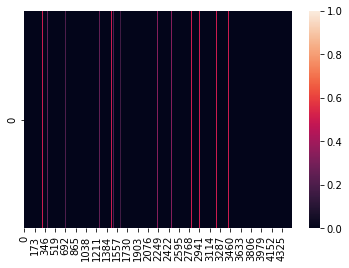

In [22]:
import seaborn as sns
cooccurence_matrix = is_model.construct_cooccurence_matrix(['Amsterdam - Coldplay'])
sns.heatmap(cooccurence_matrix)

In [23]:
is_model.get_similar_items(['Amsterdam - Coldplay'], cooccurence_matrix)

no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :355


,user_id,song,score,rank
0,,God Put A Smile Upon Your Face - Coldplay,1.000000,1
1,,Cemeteries Of London - Coldplay,0.666667,2
2,,Shifty - Flying Lotus,0.500000,3
3,,No Fit State - Hot Chip,0.500000,4
4,,Da Funk (Radio Edit) - Daft Punk,0.500000,5
5,,Melody Day - Caribou,0.500000,6
6,,Violet Hill - Coldplay,0.500000,7
7,,Silva & Grimes - Holy Fuck,0.500000,8
8,,Plastic People - Four Tet,0.500000,9
9,,My Angel Rocks Back And Forth - Four Tet,0.500000,10


Verwendung das personalisierte Empfehlungsmodell, um ähnliche Songs für den unten stehenden Song zu erhalten.

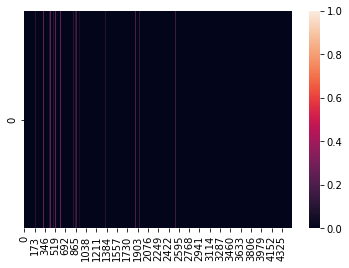

In [24]:
cooccurence_matrix = is_model.construct_cooccurence_matrix(['One - Metallica'])
sns.heatmap(cooccurence_matrix)

In [25]:
is_model.get_similar_items(['One - Metallica'], cooccurence_matrix)

no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :179


,user_id,song,score,rank
0,,Crawling (Album Version) - Linkin Park,0.400000,1
1,,Bad Company - Five Finger Death Punch,0.400000,2
2,,That Should Be Me - Justin Bieber,0.400000,3
3,,Enter Sandman - Metallica,0.400000,4
4,,My Name Is - Eminem,0.333333,5
5,,'Till I Collapse - Eminem / Nate Dogg,0.333333,6
6,,What You Know - Two Door Cinema Club,0.333333,7
7,,U Smile - Justin Bieber,0.285714,8
8,,Forever - Drake / Kanye West / Lil Wayne / Eminem,0.285714,9
9,,Red To Black (Album Version) - Fort Minor (Fea...,0.250000,10


# Quantitativer Vergleich zwischen Modellen

Jetzt werden seine Popularität und personalisierte Modelle offiziell anhand von präzisen Erinnerungskurven verglichen.

## Klasse zur Berechnung von Precision und Recall

In [26]:
from google.colab import files
src = list(files.upload().values())[0]
open('Evaluation.py','wb').write(src)
import Evaluation

Saving evaluation.py to evaluation.py


## Verwenden der obigen Precision Recall Calculator-Klasse zur Berechnung von Bewertungsmaßen

In [27]:
start = time.time()

user_sample = 0.05

pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:9c2032efba612bccec98435a3928b67d69350bed
No. of unique songs for the user: 8
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :481
Getting recommendations for user:537340ff896dea11328910013cfe759413e1eeb3
No. of unique songs for the user: 19
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :2481
Getting recommendations for user:3fef4e71c70ae99ef8a4da00e431f9cdb2b1b729
No. of unique songs for the user: 19
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :708
Getting recommendations for user:e0388a836f13f4c1f8aa600ae61625f087f40353
No. of unique songs for the user: 15
no. of unique songs in the training set: 4495
Non zero values in cooccurence_matrix :1205
Getting recommendations for user:66a0167a7c636b06efc39953aca127667beea260
No. of unique songs for the user: 13
no. of unique songs in the

## Code zum Zeichnen einer Präzisions-Erinnerungskurve

In [28]:
import pylab as pl

def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


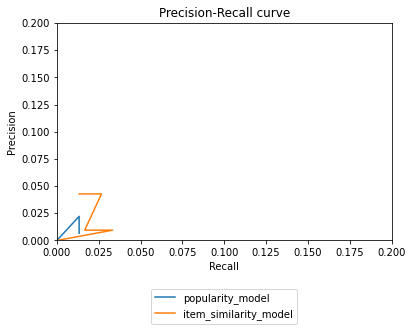

In [29]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


# Auf Matrixfaktorisierung basierendes Recommender-System

### Erforderliche Bibliotheken importieren

In [30]:
!pip install numpy
!pip install scipy
!pip install cython
!pip install sparsesvd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sparsesvd: filename=sparsesvd-0.2.2-cp37-cp37m-linux_x86_64.whl size=297875 sha256=7da0ae3d3c08470a7d8120ba52d99dd763c628ea2eeb4d2f43627017ebbcce15
  Stored in directory: /root/.cache/pip/wheels/4f/e5/2e/50014c1a0983cb8a0738d8c672ef890ef29262779c0259f1e3
Successfully built sparsesvd


In [31]:
import math as mt
import csv
from sparsesvd import sparsesvd 
import numpy as np
from scipy.sparse import csc_matrix 
from scipy.sparse.linalg import * 

### Methoden zur Berechnung von SVD und Empfehlungen

In [35]:
MAX_PID = 4
MAX_UID = 5

def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)

    return U, S, Vt

def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom


### Verwenden Sie SVD, um Vorhersagen für eine Testbenutzer-ID zu treffen, zum Beispiel 4

In [36]:
K=2

urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [5, 0,0 , 0]])
urm = csc_matrix(urm, dtype=np.float32)

U, S, Vt = computeSVD(urm, K)

uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[0 3 2 1]


## Die Intuition hinter SVD verstehen

Matrix Dimensions for U
(5, 2)


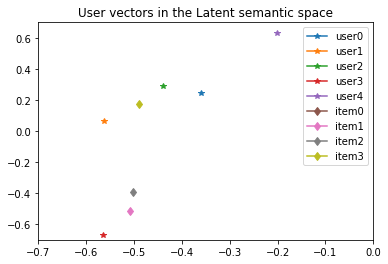

In [37]:
%matplotlib inline
from pylab import *

print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()